In [23]:
%matplotlib inline
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"


import torch
from __future__ import division, print_function
from torch.utils.data import Dataset
import glob
import os
import zarr
import random
import datetime
import numpy as np

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
# import h5py
# from imgaug import augmenters as iaa
# from imgaug.augmentables.segmaps import SegmentationMapsOnImage
# from imgaug.augmentables.heatmaps import HeatmapsOnImage
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchsummary import summary
from skimage import io
from utils.colormap import *
from unet_fov import *

plt.rcParams['image.cmap'] = 'gist_earth'
torch.backends.cudnn.benchmark = True

In [24]:
# decompress data
from shutil import unpack_archive
unpack_archive(os.path.join('datasets','example_toy_data.zip'), './')

In [25]:
def running_mean(x, n):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[n:] - cumsum[:-n]) / float(n)

def plot_history(history):
    # plot training and validation loss and binary accuracy
    
    loss = running_mean(history['loss'], 9)
    val_loss = running_mean(history['val_loss'], 9)
    #epochs = len(history.history['loss'])
    epochs = len(loss)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(range(0, epochs), loss , label='loss')
    ax1.plot(range(0, epochs), val_loss, label='val_loss')
    ax1.set_title('train and validation loss')
    ax1.legend(loc='upper right')
    
    acc = running_mean(history['binary_accuracy'], 9)
    val_acc = running_mean(history['val_binary_accuracy'], 9)

    ax2.plot(range(0, epochs), acc, label='binary_accuracy')
    ax2.plot(range(0, epochs), val_acc, label='val_binary_accuracy')
    ax2.set_title('train and validation binary accuracy')
    ax2.legend(loc='lower right')

    plt.show()

In [26]:
def show_predictions(raw, gt, pred):
    
    thresh = 0.9
    max_values = np.max(pred[:,0], axis=(1, 2))
    if np.any(max_values < thresh):
        print("Heads up: If prediction is below {} then the prediction map is shown.".format(thresh))
        print("Max predictions: {}".format(max_values))
    
    num_samples = pred.shape[0]
    fig, ax = plt.subplots(num_samples, 3, sharex=True, sharey=True, figsize=(12, num_samples * 4))
    for i in range(num_samples):
        ax[i, 0].imshow(raw[i,0], aspect="auto")
        ax[i, 1].imshow(gt[i,0], aspect="auto")
        # check for prediction threshold
        if np.sum(max_values[i]) < thresh:
            ax[i, 2].imshow(pred[i,0], aspect="auto")
        else:
            ax[i, 2].imshow(pred[i,0] >= thresh, aspect="auto")

    ax[0, 0].set_title("Input")
    ax[0, 1].set_title("Ground truth")
    ax[0, 2].set_title("Prediction")
    fig.tight_layout()

## (1) Load and visualize our toy data examples:


we have 12 train samples, 3 validation samples and 3 test samples.

In [27]:
# load tif images and reformat it
def load_dataset(in_folder):
    x = []
    y = []
    raw_files = glob.glob(in_folder + '/raw_*.tif')
    for raw_file in raw_files:
        x.append(io.imread(raw_file)) 
        y.append(io.imread(raw_file.replace('raw', 'gt'))) 
    x = np.array(x)[:, np.newaxis] #shape [N, 1, H, W]
    y = np.array(y)[:, np.newaxis] #shape [N, 1, H, W]
    return x, y

In [28]:
# load data into train/val/test sets
x_train, y_train = load_dataset('example_toy_data/train')
x_val, y_val = load_dataset('example_toy_data/val')
x_test, y_test = load_dataset('example_toy_data/test')

batch_size = 4
# make dataloaders
train_loader = DataLoader(list(zip(x_train, y_train)), batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(list(zip(x_val, y_val)), batch_size=1, pin_memory=True)
test_loader = DataLoader(list(zip(x_test, y_test)), batch_size=1)

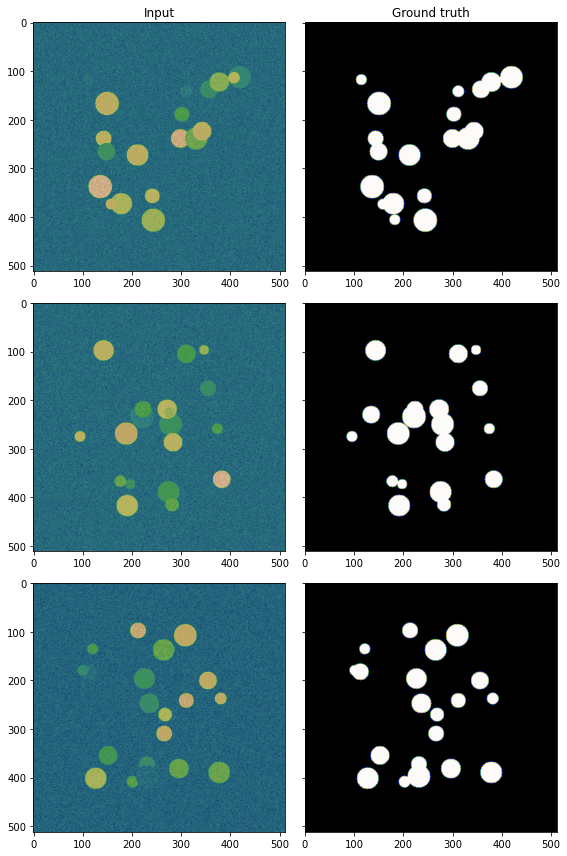

In [29]:
# show training examples
num_samples = 3
fig, ax = plt.subplots(num_samples, 2, sharey=True, figsize=(8, num_samples * 4))
for i in range(num_samples):
    ax[i, 0].imshow(x_train[i,0], aspect="auto")
    ax[i, 1].imshow(y_train[i,0], aspect="auto")
ax[0, 0].set_title("Input")
ax[0, 1].set_title("Ground truth")
fig.tight_layout()

## (2) #TODO: Create and train our model

This model is composed by stacking one UNet instance and one convolution layer. The UNet Class is defined in the **unet_fov.py** file and we use the default setting that the number of feature maps of the UNet instance output will be eqaul to the number of feature maps at the first convolution. Then we use one more convolution layer with kernel_size=1 to generate the final output with number of feature maps equal to what we want.

For the meaning of parameters of the UNet class, please refer to the **unet_fov.py** file.

#TODO:
- 1.Define the output channels of the model
- 2.Define the d_factor which is the downsampling_factor parameter of the UNet class. 
- 3.Define the activation parameter. Note: this activation parameter will be used in the later functions **training_step** and **predict**, don't confuse it with the activation parameter defined for the UNet class.
- 4.Define an UNet which use same padding with depth=4, downsampling factor=2 for each dimension. Set the activation layers inside the UNet to be "ReLU" and use str as input.

In [30]:
# set seed
torch.manual_seed(42)

###########################################################################
# TODO: Define the net and uncomment the following code                   #                     
###########################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

out_channels = 1
#d_factors is the list of 4 lists (each represents one layer)
#we downsampling the image so it should be in pair
d_factors = [[2,2],[2,2],[2,2],[2,2]]
activation = torch.sigmoid

net = torch.nn.Sequential(
     UNet(in_channels=1, #because only the intensity of input image is feeded in
     num_fmaps=32,
     fmap_inc_factors=2,
     downsample_factors=d_factors,
     activation='ReLU',
     padding='same',
     num_fmaps_out=32,
     constant_upsample=False
     ),
     torch.nn.Conv2d(in_channels=32, out_channels=out_channels, kernel_size=1, padding=0, bias=True))

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################
receptive_field, _ = net[0].get_fov()

# print network layers
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)
summary(net, (1,512,512))
print("Receptive field: ", receptive_field)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 512, 512]             320
              ReLU-2         [-1, 32, 512, 512]               0
            Conv2d-3         [-1, 32, 512, 512]           9,248
              ReLU-4         [-1, 32, 512, 512]               0
          ConvPass-5         [-1, 32, 512, 512]               0
         MaxPool2d-6         [-1, 32, 256, 256]               0
        Downsample-7         [-1, 32, 256, 256]               0
            Conv2d-8         [-1, 64, 256, 256]          18,496
              ReLU-9         [-1, 64, 256, 256]               0
           Conv2d-10         [-1, 64, 256, 256]          36,928
             ReLU-11         [-1, 64, 256, 256]               0
         ConvPass-12         [-1, 64, 256, 256]               0
        MaxPool2d-13         [-1, 64, 128, 128]               0
       Downsample-14         [-1, 64, 1

### Receptive Field of View

The number of convolutions and the depth of the U-Net are the major factors in determining the 
receptive field of the network. The term is borrowed from biology where it describes the "portion of sensory space that can elicit neuronal responses when stimulated" (wikipedia). Each output pixel can look at/depends on an input patch with that diameter centered at its position.
Based on this patch, the network has to be able to make a decision about the prediction for the respective pixel.
Yet larger sizes increase the computation time significantly.

The following code snippet visualizes the field of view of the center pixel for networks with varying depth.

Field of view at depth 1:   5 (color: yellow)
Field of view at depth 2:  18 (color: red)
Field of view at depth 3:  44 (color: green)
Field of view at depth 4:  96 (color: blue)


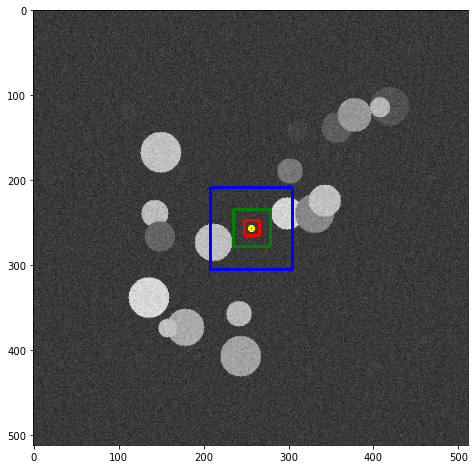

In [31]:
rnd = random.randrange(len(x_train))
image = x_train[rnd]
label = y_train[rnd]


net_t = image
fovs = []
d_factors = [[2,2],[2,2],[2,2],[2,2]]

for level in range(len(d_factors)):
    fov_tmp, _ = net[0].rec_fov(level , (1, 1), 1)
    fovs.append(fov_tmp[0])

image = np.squeeze(image)
fig=plt.figure(figsize=(8, 8))
colors = ["yellow", "red", "green", "blue", "magenta"]
plt.imshow(image, cmap='gray')
for idx, fov_t in enumerate(fovs):
    print("Field of view at depth {}: {:3d} (color: {})".format(idx+1, fov_t, colors[idx]))
    xmin = image.shape[1]/2 - fov_t/2
    xmax = image.shape[1]/2 + fov_t/2
    ymin = image.shape[1]/2 - fov_t/2
    ymax = image.shape[1]/2 + fov_t/2
    plt.hlines(ymin, xmin, xmax, color=colors[idx], lw=3)
    plt.hlines(ymax, xmin, xmax, color=colors[idx], lw=3)
    plt.vlines(xmin, ymin, ymax, color=colors[idx], lw=3)
    plt.vlines(xmax, ymin, ymax, color=colors[idx], lw=3)
plt.show()

### TODO: Define the functions for training
In the training process of semantic segmentation scenario, we usally will record two basic criteria, loss and pixel accuracy.
The loss function we use here is the Binary Cross Entropy with the sigmoid function before it.
The pixel accuracy, or accuracy for short, refers to the percent of pixels in the image which were correctly classified.

#TODO:
- 1.Define the **calc_accuracy** function according to the activation parameter you define before.This function should calculate the pixel accuracy of the prediction results average on one batch.
- 2.Call the **train** function to start the training.

In [32]:
print(torch.max(y_train))

TypeError: max(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [ ]:
###########################################################################
# TODO:  calc_accuracy function                                           #                     
###########################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

def calc_accuracy(y_pred, y_true):
    yA = torch.where(y_pred >.5,1,0)
    
    #should not use logical_and in torch because it will give (0,0) as False
    #match = torch.logical_and(yA,y_true)
    match = yA == y_true
    return torch.sum(match)/yA.nelement()


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

In [ ]:
dtype = torch.FloatTensor
def training_step(model, loss_fn, optimizer, feature, label):
    # speedup version of setting gradients to zero
    for param in model.parameters():
        param.grad = None
    # forward
    logits = model(feature) # B x C x H x W
    loss_value = loss_fn(input=logits, target=label) # label.squeeze(0) for three_class
    # backward if training mode
    if net.training:
        loss_value.backward()
        optimizer.step()
    if activation is not None:
        output = activation(logits)
    else:
        output = logits
    outputs = {
        'pred': output,
        'logits': logits,
    }
    return loss_value, outputs

def train(net, epochs, learning_rate,start_epoch=0, optimizer=None, history=None, early_stopping=None):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = net.to(device)
    loss_fn = torch.nn.BCEWithLogitsLoss()
    loss_fn = loss_fn.to(device)
    # set optimizer
    if optimizer is None:
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate) 
    if history is None:
        history = {'loss':[],
                  'val_loss':[],
                  'binary_accuracy':[],
                  'val_binary_accuracy':[]}
   
    pbar = tqdm(total=epochs*len(train_loader))
    for epoch in range(0, epochs):
    #for epoch in tqdm(range(0, epochs)):
        # reset data loader to get random augmentations
        np.random.seed()
        tmp_loader = iter(train_loader)
        train_acc_loss = []
        train_acc_accuracy = []
        net.train()
        for feature, label in tmp_loader:
            label = label.type(dtype)
            label = label.to(device)
            feature = feature.to(device)
            loss_value, outputs = training_step(net, loss_fn, optimizer, feature, label)
            pbar.update(1)
            train_acc_loss.append(loss_value.cpu().detach().numpy())
            accuracy = calc_accuracy(outputs['pred'], label)
            train_acc_accuracy.append(float(accuracy.cpu().detach().numpy()))
        history['loss'].append(np.mean(train_acc_loss))
        history['binary_accuracy'].append(np.mean(train_acc_accuracy))
        # validation
        net.eval()
        tmp_val_loader = iter(val_loader)
        val_acc_loss = []
        val_acc_accuracy = []
        for feature, label in tmp_val_loader:                    
            label = label.type(dtype)
            label = label.to(device)
            feature = feature.to(device)
            loss_value, outputs = training_step(net, loss_fn, optimizer, feature, label)
            val_acc_loss.append(loss_value.cpu().detach().numpy())
            accuracy = calc_accuracy(outputs['pred'], label)
            val_acc_accuracy.append(float(accuracy.cpu().detach().numpy()))
        history['val_loss'].append(np.mean(val_acc_loss))
        history['val_binary_accuracy'].append(np.mean(val_acc_accuracy))
        if early_stopping:
            #early_stopping(np.mean(acc_loss))
            early_stopping(np.mean(val_acc_loss))
            if early_stopping.early_stop:
                print('Early stopping after epoch', epoch)
                break
        print(f'Epoch {epoch+start_epoch+1}, train-loss: {np.mean(train_acc_loss):.4f} - train_accuracy:{np.mean(train_acc_accuracy):.4f}'+
      f' - val_loss:{np.mean(val_acc_loss):.4f} -val_accuracy:{np.mean(val_acc_accuracy):.4f}')
    return net, history, optimizer

In [33]:
num_epochs1 = 250
###########################################################################
# TODO:  train the net without using early_stopping                       #                     
###########################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

net, history, optimizer = train(net, num_epochs1, .00005)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 1, train-loss: 0.7135 - train_accuracy:0.0705 - val_loss:0.7119 -val_accuracy:0.0706
Epoch 2, train-loss: 0.7111 - train_accuracy:0.0705 - val_loss:0.7095 -val_accuracy:0.0706
Epoch 3, train-loss: 0.7086 - train_accuracy:0.0705 - val_loss:0.7071 -val_accuracy:0.0706
Epoch 4, train-loss: 0.7062 - train_accuracy:0.0705 - val_loss:0.7045 -val_accuracy:0.0706
Epoch 5, train-loss: 0.7037 - train_accuracy:0.0705 - val_loss:0.7019 -val_accuracy:0.0706
Epoch 6, train-loss: 0.7010 - train_accuracy:0.0705 - val_loss:0.6993 -val_accuracy:0.0706
Epoch 7, train-loss: 0.6983 - train_accuracy:0.0705 - val_loss:0.6966 -val_accuracy:0.0706
Epoch 8, train-loss: 0.6957 - train_accuracy:0.0705 - val_loss:0.6941 -val_accuracy:0.0710
Epoch 9, train-loss: 0.6932 - train_accuracy:0.4953 - val_loss:0.6914 -val_accuracy:0.9176
Epoch 10, train-loss: 0.6904 - train_accuracy:0.9197 - val_loss:0.6884 -val_accuracy:0.9216
Epoch 11, train-loss: 0.6873 - train_accuracy:0.9217 - val_loss:0.6850 -val_accuracy:0.92

Epoch 91, train-loss: 0.0488 - train_accuracy:0.9831 - val_loss:0.0658 -val_accuracy:0.9852
Epoch 92, train-loss: 0.0465 - train_accuracy:0.9847 - val_loss:0.0652 -val_accuracy:0.9854
Epoch 93, train-loss: 0.0477 - train_accuracy:0.9841 - val_loss:0.0568 -val_accuracy:0.9862
Epoch 94, train-loss: 0.0442 - train_accuracy:0.9851 - val_loss:0.0653 -val_accuracy:0.9865
Epoch 95, train-loss: 0.0440 - train_accuracy:0.9859 - val_loss:0.0643 -val_accuracy:0.9864
Epoch 96, train-loss: 0.0423 - train_accuracy:0.9861 - val_loss:0.0531 -val_accuracy:0.9872
Epoch 97, train-loss: 0.0427 - train_accuracy:0.9860 - val_loss:0.0527 -val_accuracy:0.9867
Epoch 98, train-loss: 0.0418 - train_accuracy:0.9867 - val_loss:0.0645 -val_accuracy:0.9868
Epoch 99, train-loss: 0.0423 - train_accuracy:0.9859 - val_loss:0.0543 -val_accuracy:0.9869
Epoch 100, train-loss: 0.0416 - train_accuracy:0.9861 - val_loss:0.0587 -val_accuracy:0.9826
Epoch 101, train-loss: 0.0405 - train_accuracy:0.9861 - val_loss:0.0651 -val_ac

Epoch 180, train-loss: 0.0183 - train_accuracy:0.9940 - val_loss:0.0496 -val_accuracy:0.9807
Epoch 181, train-loss: 0.0182 - train_accuracy:0.9938 - val_loss:0.0519 -val_accuracy:0.9801
Epoch 182, train-loss: 0.0171 - train_accuracy:0.9943 - val_loss:0.0430 -val_accuracy:0.9836
Epoch 183, train-loss: 0.0176 - train_accuracy:0.9941 - val_loss:0.0486 -val_accuracy:0.9820
Epoch 184, train-loss: 0.0168 - train_accuracy:0.9944 - val_loss:0.0597 -val_accuracy:0.9770
Epoch 185, train-loss: 0.0165 - train_accuracy:0.9945 - val_loss:0.0608 -val_accuracy:0.9773
Epoch 186, train-loss: 0.0172 - train_accuracy:0.9944 - val_loss:0.0594 -val_accuracy:0.9779
Epoch 187, train-loss: 0.0169 - train_accuracy:0.9943 - val_loss:0.0375 -val_accuracy:0.9863
Epoch 188, train-loss: 0.0200 - train_accuracy:0.9938 - val_loss:0.0649 -val_accuracy:0.9757
Epoch 189, train-loss: 0.0181 - train_accuracy:0.9940 - val_loss:0.0573 -val_accuracy:0.9777
Epoch 190, train-loss: 0.0173 - train_accuracy:0.9940 - val_loss:0.048

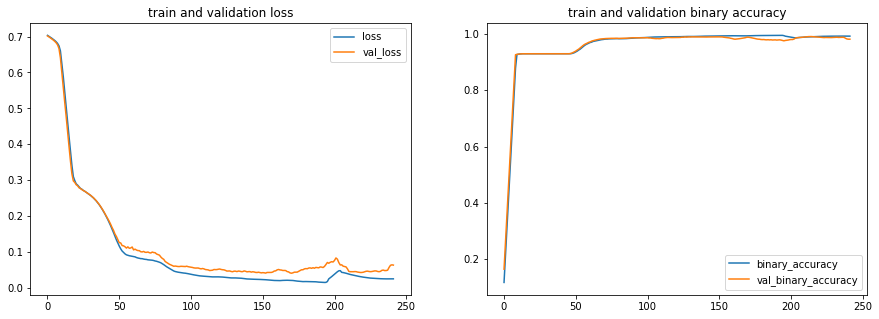

In [34]:
# plot loss and accuracy
plot_history(history)

## (3) Test and evaluate our model

Accuracy: 0.959


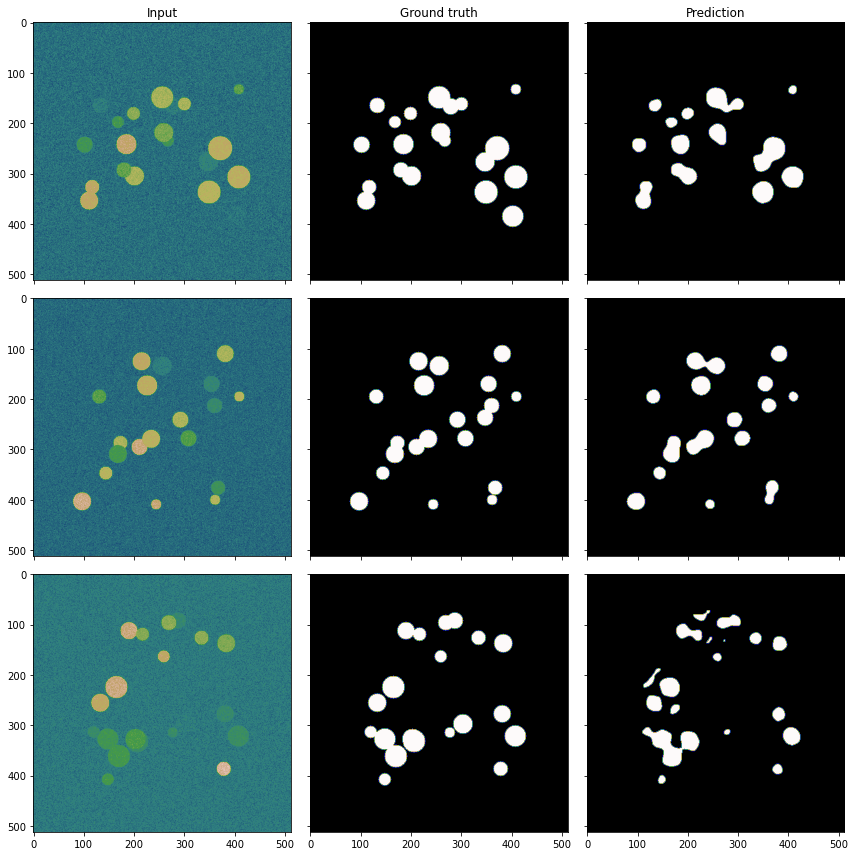

In [35]:
# predict the test set
def predict(net, test_loader):
    net.eval()
    predictions = []
    acc_accuracy = []
    for image, label in test_loader:
        image = image.to(device)
        label = label.to(device)
        pred = net(image)
        pred = activation(pred)
        accuracy = calc_accuracy(pred, label)
        acc_accuracy.append(float(accuracy.cpu().detach().numpy()))
        image = np.squeeze(image.cpu())
        pred = np.squeeze(pred.cpu().detach().numpy(),0)
        predictions.append(pred)
    return predictions, float(np.mean(acc_accuracy))
    
# plot predicted results
predictions, mean_accuracy = predict(net, test_loader)
predictions = np.stack(predictions, axis=0)
print('Accuracy: {:.3f}'.format(mean_accuracy))
show_predictions(x_test, y_test, predictions)

### A1: #TODO: Continue training for more epochs

In [36]:
# continue training, takes ~3min
# heads up: the "net" variable still carries all the information from the previous training
num_epochs2=160
###########################################################################
# TODO:  continue to train the net without using early_stopping           #   
# remember to give the history parameter this time                        # 
###########################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

net, history, optimizer = train(net, num_epochs2,0.00005)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################


print('Finished Training')

  0%|          | 0/480 [00:00<?, ?it/s]

Epoch 1, train-loss: 0.0360 - train_accuracy:0.9882 - val_loss:0.3847 -val_accuracy:0.8091
Epoch 2, train-loss: 0.0401 - train_accuracy:0.9876 - val_loss:0.0799 -val_accuracy:0.9733
Epoch 3, train-loss: 0.0275 - train_accuracy:0.9915 - val_loss:0.0353 -val_accuracy:0.9865
Epoch 4, train-loss: 0.0311 - train_accuracy:0.9909 - val_loss:0.0226 -val_accuracy:0.9929
Epoch 5, train-loss: 0.0309 - train_accuracy:0.9897 - val_loss:0.0228 -val_accuracy:0.9931
Epoch 6, train-loss: 0.0256 - train_accuracy:0.9923 - val_loss:0.0284 -val_accuracy:0.9895
Epoch 7, train-loss: 0.0269 - train_accuracy:0.9920 - val_loss:0.0301 -val_accuracy:0.9899
Epoch 8, train-loss: 0.0248 - train_accuracy:0.9926 - val_loss:0.0315 -val_accuracy:0.9919
Epoch 9, train-loss: 0.0258 - train_accuracy:0.9924 - val_loss:0.0331 -val_accuracy:0.9905
Epoch 10, train-loss: 0.0247 - train_accuracy:0.9926 - val_loss:0.0353 -val_accuracy:0.9873
Epoch 11, train-loss: 0.0243 - train_accuracy:0.9924 - val_loss:0.0326 -val_accuracy:0.98

Epoch 91, train-loss: 0.0092 - train_accuracy:0.9965 - val_loss:0.0354 -val_accuracy:0.9883
Epoch 92, train-loss: 0.0089 - train_accuracy:0.9966 - val_loss:0.0376 -val_accuracy:0.9873
Epoch 93, train-loss: 0.0088 - train_accuracy:0.9966 - val_loss:0.0276 -val_accuracy:0.9922
Epoch 94, train-loss: 0.0089 - train_accuracy:0.9966 - val_loss:0.0274 -val_accuracy:0.9918
Epoch 95, train-loss: 0.0086 - train_accuracy:0.9967 - val_loss:0.0280 -val_accuracy:0.9920
Epoch 96, train-loss: 0.0085 - train_accuracy:0.9968 - val_loss:0.0289 -val_accuracy:0.9929
Epoch 97, train-loss: 0.0088 - train_accuracy:0.9967 - val_loss:0.0292 -val_accuracy:0.9906
Epoch 98, train-loss: 0.0086 - train_accuracy:0.9968 - val_loss:0.0301 -val_accuracy:0.9899
Epoch 99, train-loss: 0.0084 - train_accuracy:0.9969 - val_loss:0.0249 -val_accuracy:0.9924
Epoch 100, train-loss: 0.0082 - train_accuracy:0.9969 - val_loss:0.0251 -val_accuracy:0.9925
Epoch 101, train-loss: 0.0081 - train_accuracy:0.9970 - val_loss:0.0283 -val_ac

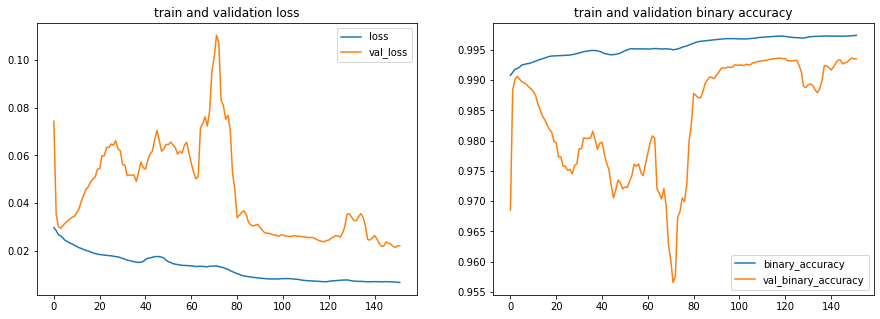

In [37]:
# plot loss and accuracy
plot_history(history)

Accuracy: 0.975


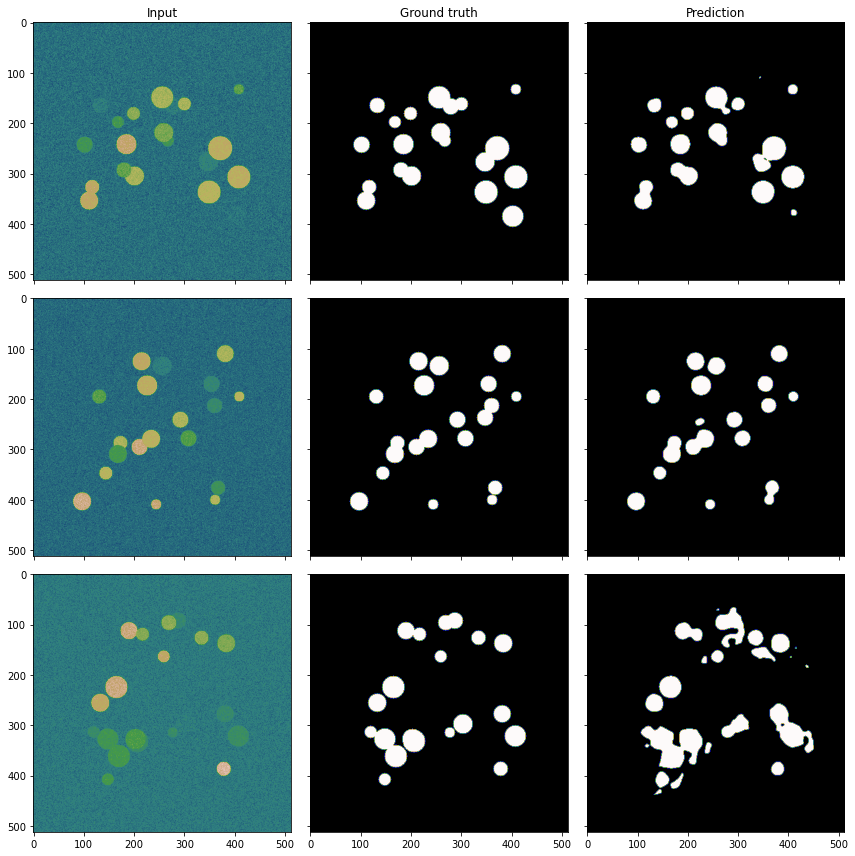

In [38]:
# evaluate and plot predicted results
predictions, mean_accuracy = predict(net, test_loader)
predictions = np.stack(predictions, axis=0)
print('Accuracy: {:.3f}'.format(mean_accuracy))
show_predictions(x_test, y_test, predictions)

#### The training of the networks depend on many hyperparameters such as
- network architecture: #layers, #fmaps
- batch size, learning rate
- number and distribution of the training samples

#### You can play and see how these settings influence the learning curve.
![image.png](utils/example_learning_curves/lc_all.png)

![](example_learning_curves/lc_all.png)

### A2:  #TODO: Use early stopping to avoid overfitting
#TODO:
- 1.Define the net.
- 2.Look the EarlyStopping Class defined below and create an EarlyStopping instance.
- 3.Train the net with early-stopping function working.

In [39]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    Code from https://debuggercafe.com/using-learning-rate-scheduler-and-early-stopping-with-pytorch/
    """
    def __init__(self, patience=20, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [40]:
# define model

###########################################################################
# TODO: Define the net and uncomment the following code                   #
# You can basically copy the code that you use to define the net before   # 
# Please also define the early_stopping                                   # 
###########################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


out_channels = 1
#d_factors is the list of 4 lists (each represents one layer)
#we downsampling the image so it should be in pair
d_factors = [[2,2],[2,2],[2,2],[2,2]]
activation = torch.sigmoid
early_stopping = 100

net = torch.nn.Sequential(
     UNet(in_channels=1, #because only the intensity of input image is feeded in
     num_fmaps=32,
     fmap_inc_factors=2,
     downsample_factors=d_factors,
     activation='ReLU',
     padding='same',
     num_fmaps_out=32,
     constant_upsample=False
     ),
     torch.nn.Conv2d(in_channels=32, out_channels=out_channels, kernel_size=1, padding=0, bias=True))

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################


In [41]:
# train model
epochs = 500
###########################################################################
# TODO:  train the net and use early_stopping                             #   
###########################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

net, history_w_ea,_ = train(net, epochs, 0.00005)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################
print('Finished Training')

  0%|          | 0/1500 [00:00<?, ?it/s]

Epoch 1, train-loss: 0.6585 - train_accuracy:0.9295 - val_loss:0.6570 -val_accuracy:0.9294
Epoch 2, train-loss: 0.6561 - train_accuracy:0.9295 - val_loss:0.6546 -val_accuracy:0.9294
Epoch 3, train-loss: 0.6538 - train_accuracy:0.9295 - val_loss:0.6523 -val_accuracy:0.9294
Epoch 4, train-loss: 0.6516 - train_accuracy:0.9295 - val_loss:0.6502 -val_accuracy:0.9294
Epoch 5, train-loss: 0.6495 - train_accuracy:0.9295 - val_loss:0.6481 -val_accuracy:0.9294
Epoch 6, train-loss: 0.6474 - train_accuracy:0.9295 - val_loss:0.6458 -val_accuracy:0.9294
Epoch 7, train-loss: 0.6451 - train_accuracy:0.9295 - val_loss:0.6434 -val_accuracy:0.9294
Epoch 8, train-loss: 0.6428 - train_accuracy:0.9295 - val_loss:0.6410 -val_accuracy:0.9294
Epoch 9, train-loss: 0.6405 - train_accuracy:0.9295 - val_loss:0.6389 -val_accuracy:0.9294
Epoch 10, train-loss: 0.6383 - train_accuracy:0.9295 - val_loss:0.6365 -val_accuracy:0.9294
Epoch 11, train-loss: 0.6358 - train_accuracy:0.9295 - val_loss:0.6337 -val_accuracy:0.92

Epoch 91, train-loss: 0.0361 - train_accuracy:0.9878 - val_loss:0.0436 -val_accuracy:0.9899
Epoch 92, train-loss: 0.0352 - train_accuracy:0.9889 - val_loss:0.0490 -val_accuracy:0.9905
Epoch 93, train-loss: 0.0330 - train_accuracy:0.9893 - val_loss:0.0648 -val_accuracy:0.9854
Epoch 94, train-loss: 0.0326 - train_accuracy:0.9898 - val_loss:0.0654 -val_accuracy:0.9889
Epoch 95, train-loss: 0.0315 - train_accuracy:0.9900 - val_loss:0.0543 -val_accuracy:0.9905
Epoch 96, train-loss: 0.0300 - train_accuracy:0.9903 - val_loss:0.0507 -val_accuracy:0.9890
Epoch 97, train-loss: 0.0318 - train_accuracy:0.9895 - val_loss:0.0623 -val_accuracy:0.9871
Epoch 98, train-loss: 0.0411 - train_accuracy:0.9864 - val_loss:0.0811 -val_accuracy:0.9871
Epoch 99, train-loss: 0.0363 - train_accuracy:0.9882 - val_loss:0.0482 -val_accuracy:0.9913
Epoch 100, train-loss: 0.0334 - train_accuracy:0.9889 - val_loss:0.0546 -val_accuracy:0.9880
Epoch 101, train-loss: 0.0333 - train_accuracy:0.9896 - val_loss:0.1781 -val_ac

Epoch 180, train-loss: 0.0198 - train_accuracy:0.9930 - val_loss:0.0363 -val_accuracy:0.9911
Epoch 181, train-loss: 0.0203 - train_accuracy:0.9931 - val_loss:0.1053 -val_accuracy:0.9719
Epoch 182, train-loss: 0.0194 - train_accuracy:0.9934 - val_loss:0.1418 -val_accuracy:0.9445
Epoch 183, train-loss: 0.0188 - train_accuracy:0.9939 - val_loss:0.1814 -val_accuracy:0.9037
Epoch 184, train-loss: 0.0183 - train_accuracy:0.9940 - val_loss:0.0572 -val_accuracy:0.9903
Epoch 185, train-loss: 0.0181 - train_accuracy:0.9938 - val_loss:0.0579 -val_accuracy:0.9897
Epoch 186, train-loss: 0.0188 - train_accuracy:0.9940 - val_loss:0.1414 -val_accuracy:0.9411
Epoch 187, train-loss: 0.0176 - train_accuracy:0.9938 - val_loss:0.0818 -val_accuracy:0.9829
Epoch 188, train-loss: 0.0181 - train_accuracy:0.9935 - val_loss:0.1151 -val_accuracy:0.9615
Epoch 189, train-loss: 0.0177 - train_accuracy:0.9937 - val_loss:0.0922 -val_accuracy:0.9761
Epoch 190, train-loss: 0.0178 - train_accuracy:0.9940 - val_loss:0.052

Epoch 269, train-loss: 0.0160 - train_accuracy:0.9946 - val_loss:0.1050 -val_accuracy:0.9593
Epoch 270, train-loss: 0.0156 - train_accuracy:0.9948 - val_loss:0.1685 -val_accuracy:0.9335
Epoch 271, train-loss: 0.0149 - train_accuracy:0.9949 - val_loss:0.0741 -val_accuracy:0.9726
Epoch 272, train-loss: 0.0152 - train_accuracy:0.9948 - val_loss:0.1583 -val_accuracy:0.9378
Epoch 273, train-loss: 0.0151 - train_accuracy:0.9947 - val_loss:0.0808 -val_accuracy:0.9696
Epoch 274, train-loss: 0.0149 - train_accuracy:0.9949 - val_loss:0.1317 -val_accuracy:0.9483
Epoch 275, train-loss: 0.0149 - train_accuracy:0.9950 - val_loss:0.1049 -val_accuracy:0.9594
Epoch 276, train-loss: 0.0147 - train_accuracy:0.9950 - val_loss:0.1524 -val_accuracy:0.9399
Epoch 277, train-loss: 0.0144 - train_accuracy:0.9951 - val_loss:0.0902 -val_accuracy:0.9657
Epoch 278, train-loss: 0.0142 - train_accuracy:0.9952 - val_loss:0.1007 -val_accuracy:0.9611
Epoch 279, train-loss: 0.0140 - train_accuracy:0.9952 - val_loss:0.105

Epoch 358, train-loss: 0.0094 - train_accuracy:0.9964 - val_loss:0.0772 -val_accuracy:0.9721
Epoch 359, train-loss: 0.0095 - train_accuracy:0.9964 - val_loss:0.1113 -val_accuracy:0.9547
Epoch 360, train-loss: 0.0093 - train_accuracy:0.9965 - val_loss:0.1149 -val_accuracy:0.9529
Epoch 361, train-loss: 0.0092 - train_accuracy:0.9965 - val_loss:0.0599 -val_accuracy:0.9814
Epoch 362, train-loss: 0.0108 - train_accuracy:0.9958 - val_loss:0.1613 -val_accuracy:0.9294
Epoch 363, train-loss: 0.0099 - train_accuracy:0.9961 - val_loss:0.0868 -val_accuracy:0.9674
Epoch 364, train-loss: 0.0103 - train_accuracy:0.9960 - val_loss:0.0546 -val_accuracy:0.9839
Epoch 365, train-loss: 0.0103 - train_accuracy:0.9961 - val_loss:0.2813 -val_accuracy:0.8667
Epoch 366, train-loss: 0.0100 - train_accuracy:0.9961 - val_loss:0.0621 -val_accuracy:0.9812
Epoch 367, train-loss: 0.0100 - train_accuracy:0.9960 - val_loss:0.1705 -val_accuracy:0.9242
Epoch 368, train-loss: 0.0097 - train_accuracy:0.9962 - val_loss:0.107

Epoch 447, train-loss: 0.0069 - train_accuracy:0.9974 - val_loss:0.1067 -val_accuracy:0.9562
Epoch 448, train-loss: 0.0069 - train_accuracy:0.9974 - val_loss:0.0784 -val_accuracy:0.9709
Epoch 449, train-loss: 0.0069 - train_accuracy:0.9975 - val_loss:0.0723 -val_accuracy:0.9741
Epoch 450, train-loss: 0.0069 - train_accuracy:0.9975 - val_loss:0.1199 -val_accuracy:0.9490
Epoch 451, train-loss: 0.0072 - train_accuracy:0.9973 - val_loss:0.1592 -val_accuracy:0.9279
Epoch 452, train-loss: 0.0071 - train_accuracy:0.9973 - val_loss:0.0668 -val_accuracy:0.9768
Epoch 453, train-loss: 0.0069 - train_accuracy:0.9974 - val_loss:0.1531 -val_accuracy:0.9316
Epoch 454, train-loss: 0.0069 - train_accuracy:0.9974 - val_loss:0.1000 -val_accuracy:0.9599
Epoch 455, train-loss: 0.0070 - train_accuracy:0.9974 - val_loss:0.0689 -val_accuracy:0.9758
Epoch 456, train-loss: 0.0068 - train_accuracy:0.9974 - val_loss:0.0809 -val_accuracy:0.9699
Epoch 457, train-loss: 0.0069 - train_accuracy:0.9975 - val_loss:0.075

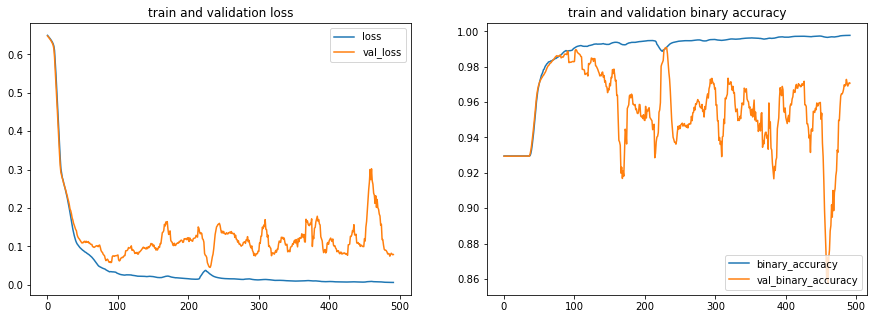

In [42]:
# plot loss and accuracy
plot_history(history_w_ea)

Accuracy: 0.749


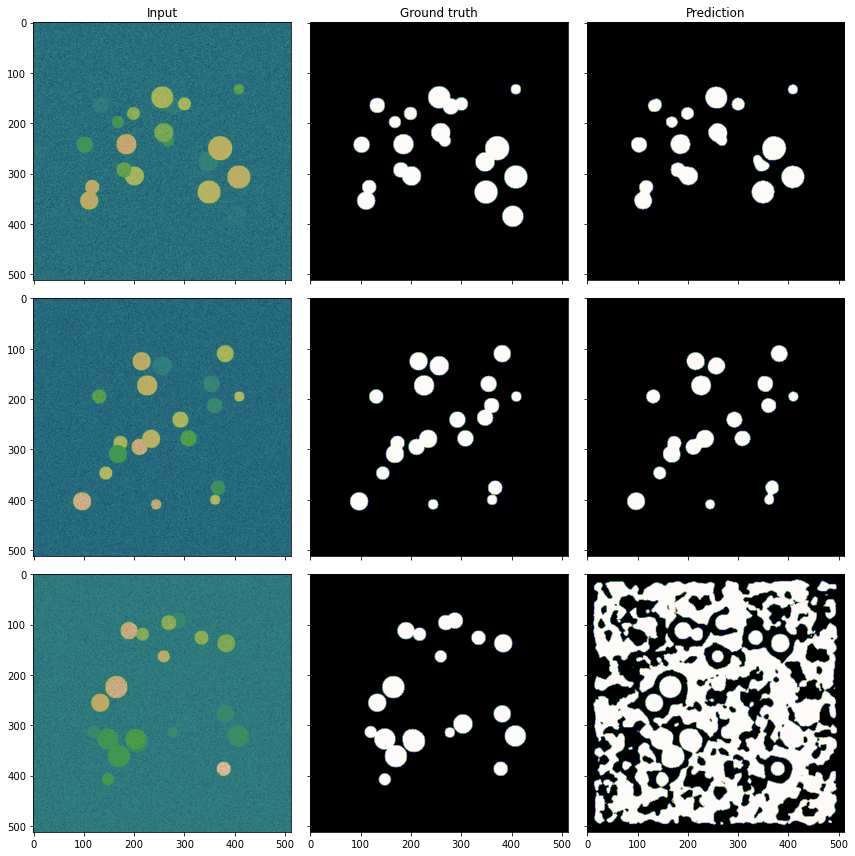

In [43]:
# evaluate and plot predicted results
predictions, mean_accuracy = predict(net, test_loader)
predictions = np.stack(predictions, axis=0)
print('Accuracy: {:.3f}'.format(mean_accuracy))
show_predictions(x_test, y_test, predictions)